<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# <a id='toc1_'></a>[Convolutional Neural Network for Anime Image Classification](#toc0_)


**Table of contents**<a id='toc0_'></a>    
- [Convolutional Neural Network for Anime Image Classification](#toc1_)    
  - [Objectives](#toc1_1_)    
  - [Setup](#toc1_2_)    
    - [Installing Required Libraries](#toc1_2_1_)    
    - [Importing Required Libraries](#toc1_2_2_)    
  - [Load the Data](#toc1_3_)    
    - [Visualize the Dataset](#toc1_3_1_)    
  - [Define Custom Dataset Class](#toc1_4_)    
  - [Split Dataset into Training and Validation Sets](#toc1_5_)    
  - [Define the CNN Model](#toc1_6_)    
  - [Define Loss Function and Optimizer](#toc1_7_)    
  - [Train the Model](#toc1_8_)    
  - [Visualize the Training and Test Loss](#toc1_9_)    
  - [Exercises](#toc1_10_)    
    - [Exercise 1 - Change activation function to `leaky_relu`](#toc1_10_1_)    
    - [Exercise 2 - Increase the number of epochs and observe the training and validation loss](#toc1_10_2_)    
    - [Exercise 3 - Use different character classes for training and validation](#toc1_10_3_)    
  - [Authors](#toc1_11_)    
  - [Contributors](#toc1_12_)    


Estimated time needed: **30** minutes


This tutorial demonstrates how to build and train a **Convolutional Neural Network (CNN)** for image classification. The goal is to train a model that can classify images into the correct categories.


## <a id='toc1_1_'></a>[Objectives](#toc0_)

After completing this lab you will be able to:

 - Apply **Convolutional Neural Network** to classify images.


----


## <a id='toc1_2_'></a>[Setup](#toc0_)

For this lab, we will be using the following libraries:

*   [`pandas`](https://pandas.pydata.org/) for managing the data.
*   [`numpy`](https://numpy.org/) for mathematical operations.
*   [`matplotlib`](https://matplotlib.org/) for additional plotting tools.
*   [`sklearn`](https://scikit-learn.org/stable/) for machine learning and machine-learning-pipeline related functions.
*   [`torch`](https://pytorch.org/) for building and training the deep neural network.
*   [`torchvision`](https://pytorch.org/vision/stable/index.html) for computer vision tasks.


### <a id='toc1_2_1_'></a>[Installing Required Libraries](#toc0_)

The following required libraries are __not__ pre-installed in the Skills Network Labs environment. __You will need to run the following cell__ to install them:

NOTE: It may take **a few minutes** to install the required libraries. Please be patient.


In [1]:
!pip install pandas==2.2.2
!pip install numpy==1.26.4
!pip install matplotlib==3.8.0
!pip install scikit-learn==1.5.0
!pip install torch==2.3.1
!pip install torchvision==0.18.1

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   -------- ------------------------------- 0.3/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 4.2 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.0
    Uninstalling torchvision-0.20.0:
      Successfully uninstalled torchvision-0.20.0


### <a id='toc1_2_2_'></a>[Importing Required Libraries](#toc0_)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from PIL import Image

## <a id='toc1_3_'></a>[Load the Data](#toc0_)

First, let's load our dataset and examine its structure.

The data comes from the paper [AniWho: A Quick and Accurate Way to Classify Anime Character Faces in Images](https://arxiv.org/pdf/2208.11012v3). The dataset consists of 9,738 images across 130 character classes, with approximately 75 images per class, sourced from the Danbooru website—a platform developed by the Japanese animation-style cartoon community.

For this tutorial, we will use a subset of the dataset. The zip file contains two subfolders: **Anastasia** and **Takao**, each with 50 images.

Let's unzip the dataset.


In [3]:
import io
import requests

def load_images_from_zip(zip_file):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        images = {'anastasia': [], 'takao': []}
        for file_name in zip_ref.namelist():
            if file_name.startswith('anastasia') and file_name.endswith('.jpg'):
                with zip_ref.open(file_name) as file:
                    img = Image.open(file).convert('RGB')
                    images['anastasia'].append(np.array(img))
            elif file_name.startswith('takao') and file_name.endswith('.jpg'):
                with zip_ref.open(file_name) as file:
                    img = Image.open(file).convert('RGB')
                    images['takao'].append(np.array(img))
    return images

zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/xZQHOyN8ONT92kH-ASb4Pw/data.zip'

# Download the ZIP file
response = requests.get(zip_file_url)
zip_file_bytes = io.BytesIO(response.content)

# Load images from zip file
images = load_images_from_zip(zip_file_bytes)

Let us check the number of images in each folder.


In [4]:
print("Number of images of Anastasia:", len(images['anastasia']))
print("Number of images of Takao:", len(images['takao']))

Number of images of Anastasia: 50
Number of images of Takao: 50


### <a id='toc1_3_1_'></a>[Visualize the Dataset](#toc0_)

Let's visualize images from the dataset. Since we have 50 images in each folder, we will display all the images in a grid.


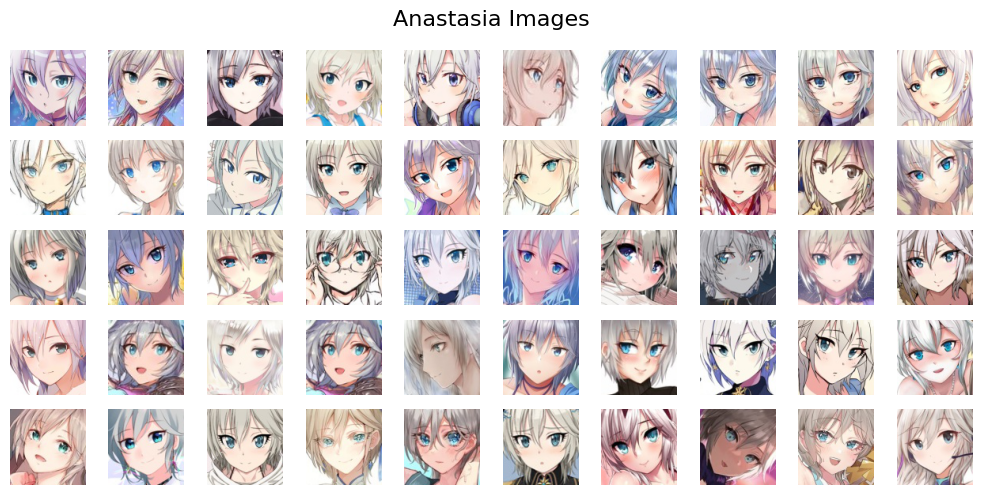

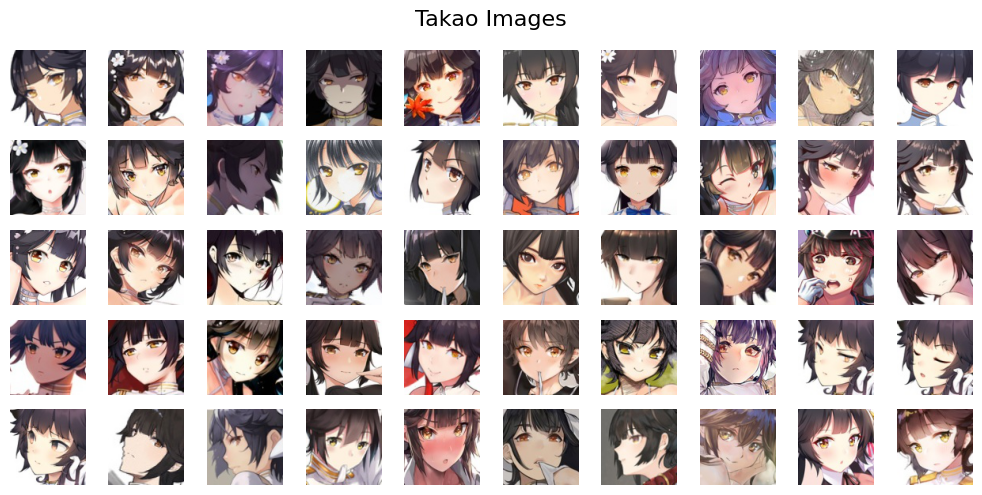

In [5]:
def plot_images(images, title):
    fig, axes = plt.subplots(5, 10, figsize=(10, 5))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Plot images from 'anastasia'
plot_images(images['anastasia'], 'Anastasia Images')

# Plot images from 'takao'
plot_images(images['takao'], 'Takao Images')

## <a id='toc1_4_'></a>[Define Custom Dataset Class](#toc0_)

We need to define a custom dataset class to load our images. This class will inherit from `torch.utils.data.Dataset`.


In [6]:
class AnimeDataset(Dataset):
    def __init__(self, images, transform=None, classes=None):
        self.images = []
        self.labels = []
        self.transform = transform
        self.classes = classes
        
        for label, class_name in enumerate(self.classes):
            for img in images[class_name]:
                self.images.append(img)
                self.labels.append(label)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
dataset = AnimeDataset(images, transform=transform, classes=['anastasia', 'takao'])


## <a id='toc1_5_'></a>[Split Dataset into Training and Validation Sets](#toc0_)

We will split the dataset into **training** and **validation** sets and create DataLoader for each.

The data is split into **80%** training and **20%** validation sets.

We then print the shapes of the training and test sets to verify that the data has been split correctly.


In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Generate a list of indices for the entire dataset
indices = list(range(len(dataset)))

# Split the indices into training and validation sets
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=seed)

# Create samplers for training and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create DataLoader objects for training and validation sets
train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=20, sampler=val_sampler)

# Print the sizes of the training and validation sets
print("Train size:", len(train_indices))
print("Validation size:", len(val_indices))

Train size: 80
Validation size: 20


## <a id='toc1_6_'></a>[Define the CNN Model](#toc0_)

Now, let's define our CNN model. We will use `torch.nn` to build the model.


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class AnimeCNN(nn.Module):
    def __init__(self):
        super(AnimeCNN, self).__init__()
        # Add padding=1 to maintain the border
        self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = AnimeCNN()

Let us visualize the neural network architecture.


In [9]:
print(model)

AnimeCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


Let us print the tensor shapes of each layer in the model.


In [10]:
input_tensor = torch.randn(1, 3, 64, 64)

def print_size(module, input, output):
    print(f"{module.__class__.__name__} output size: {output.size()}")

# Register hooks
hooks = []
for layer in model.children():
    hook = layer.register_forward_hook(print_size)
    hooks.append(hook)

# Inspect output sizes
with torch.no_grad():
    output = model(input_tensor)
print("Final output size:", output.size())

# Remove hooks
for hook in hooks:
    hook.remove()

Conv2d output size: torch.Size([1, 32, 64, 64])
MaxPool2d output size: torch.Size([1, 32, 32, 32])
Conv2d output size: torch.Size([1, 64, 32, 32])
MaxPool2d output size: torch.Size([1, 64, 16, 16])
Linear output size: torch.Size([1, 128])
Linear output size: torch.Size([1, 2])
Final output size: torch.Size([1, 2])


## <a id='toc1_7_'></a>[Define Loss Function and Optimizer](#toc0_)

We need to define the loss function and the optimizer. We will use CrossEntropyLoss and Adam optimizer.

`CrossEntropyLoss` is used for multi-class classification problems.

`Adam` is a popular optimization algorithm that is an extension of the stochastic gradient descent algorithm.


In [11]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## <a id='toc1_8_'></a>[Train the Model](#toc0_)

Now, let's train the model with our training data. We iterate over the training data for a specified number of epochs and update the weights of the neural network using backpropagation.

During training, we calculate the loss at each epoch and print it to monitor the training progress. The loss should decrease over time as the model learns to classify the wines correctly.


In [12]:
import matplotlib.pyplot as plt
import torch

# Training loop
num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print('Finished Training')



Epoch 1, Train Loss: 0.7387, Val Loss: 0.1970
Epoch 2, Train Loss: 0.1920, Val Loss: 0.0012
Epoch 3, Train Loss: 0.0488, Val Loss: 0.0004
Epoch 4, Train Loss: 0.0059, Val Loss: 0.0003
Epoch 5, Train Loss: 0.0007, Val Loss: 0.0002
Finished Training


## <a id='toc1_9_'></a>[Visualize the Training and Test Loss](#toc0_)

We have successfully trained our model. Let's now visualize the training and test loss.

Plotting the loss curves helps us understand the training dynamics of our model.


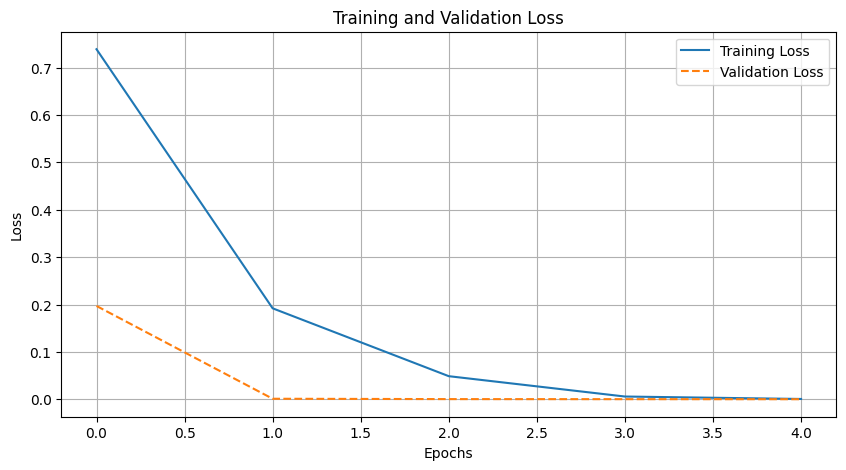

In [13]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()


Finally, we evaluate the model on the validation data to see how well it performs on unseen data.

We check the model's performance on individual images from the validation set. The model classifies most of the images correctly.


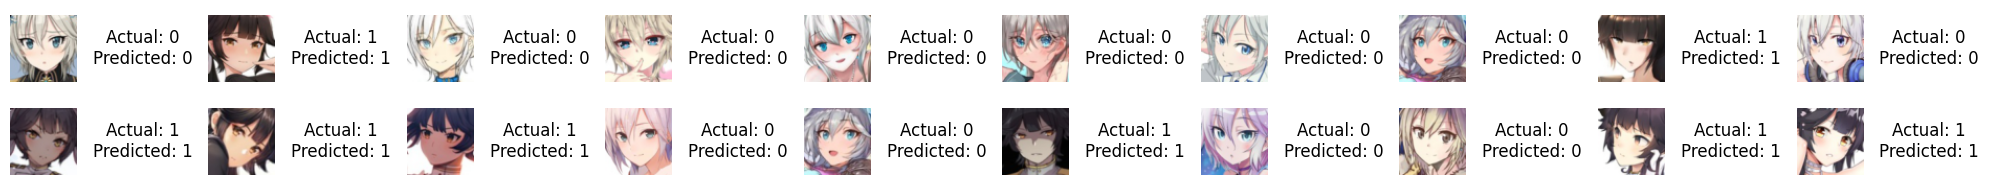

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to display an image
def imshow(img, ax):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose dimensions to match matplotlib's expected format
    ax.axis('off')

# Set model to evaluation mode
model.eval()

data_iter = iter(val_loader)
images, labels = next(data_iter)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Define the grid size
num_images = len(images)
num_cols = 10
num_rows = 2

fig, axs = plt.subplots(num_rows, num_cols * 2, figsize=(20, num_rows))

for idx in range(num_images):
    row = idx // num_cols
    col = (idx % num_cols) * 2
    
    # Plot the image
    imshow(images[idx].cpu(), axs[row, col])
    
    # Display actual and predicted labels
    axs[row, col + 1].text(0.5, 0.5, f"Actual: {labels[idx].item()}\nPredicted: {predicted[idx].item()}",
                           horizontalalignment='center', verticalalignment='center', fontsize=12)
    axs[row, col + 1].axis('off')

# Turn off any remaining empty subplots
for idx in range(num_images, num_rows * num_cols):
    row = idx // num_cols
    col = (idx % num_cols) * 2
    axs[row, col].axis('off')
    axs[row, col + 1].axis('off')

plt.tight_layout()
plt.show()

We calculate the accuracy of the model on the validation set to measure its performance. 

The accuracy is the percentage of correctly classified samples in the validation set. A higher accuracy indicates better performance of the model. 


In [15]:
correct = 0
total = 0

# Compute overall accuracy
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f'correct: {correct}, total: {total}')

print(f'Validation Accuracy: {100 * correct / total:.2f}%')

correct: 20, total: 20
Validation Accuracy: 100.00%


## <a id='toc1_10_'></a>[Exercises](#toc0_)


### <a id='toc1_10_1_'></a>[Exercise 1 - Change activation function to `leaky_relu`](#toc0_)


In [16]:
class AnimeCNNModified(nn.Module):
    def __init__(self):
        super(AnimeCNNModified, self).__init__()
        # Add padding=1 to maintain the border
        self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))  # Change activation function here
        x = self.pool(F.leaky_relu(self.conv2(x)))  # Change activation function here
        x = x.view(-1, 64 * 16 * 16)
        x = F.leaky_relu(self.fc1(x))  # Change activation function here
        x = self.fc2(x)
        return x

<details>
    <summary>Click here for Solution</summary>

```python
class AnimeCNNModified(nn.Module):
    def __init__(self):
        super(AnimeCNNModified, self).__init__()
        # Add padding=1 to maintain the border
        self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))  # Change activation function here
        x = self.pool(F.leaky_relu(self.conv2(x)))  # Change activation function here
        x = x.view(-1, 64 * 16 * 16)
        x = F.leaky_relu(self.fc1(x))  # Change activation function here
        x = self.fc2(x)
        return x
```

</details>


### <a id='toc1_10_2_'></a>[Exercise 2 - Increase the number of epochs and observe the training and validation loss](#toc0_)

After increasing the number of epochs, you should observe that the training and validation loss decrease further. However, it may stop decreasing after a certain number of epochs.


Epoch 1, Train Loss: 0.2981, Val Loss: 0.0387
Epoch 2, Train Loss: 0.0867, Val Loss: 0.0140
Epoch 3, Train Loss: 0.0338, Val Loss: 0.0002
Epoch 4, Train Loss: 0.0201, Val Loss: 0.0013
Epoch 5, Train Loss: 0.0025, Val Loss: 0.0003
Epoch 6, Train Loss: 0.0004, Val Loss: 0.0002
Epoch 7, Train Loss: 0.0003, Val Loss: 0.0001
Epoch 8, Train Loss: 0.0002, Val Loss: 0.0001
Epoch 9, Train Loss: 0.0002, Val Loss: 0.0001
Epoch 10, Train Loss: 0.0002, Val Loss: 0.0001
Finished Training


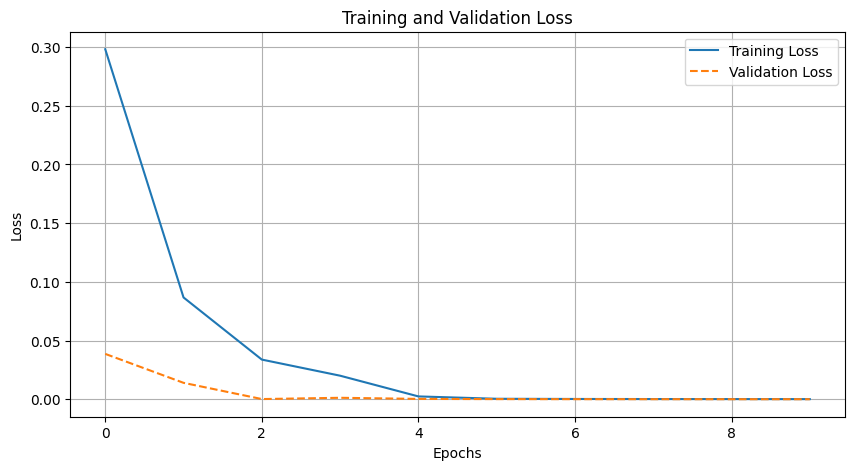

In [17]:
# Instantiate the model
model_new = AnimeCNN()

import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_new.parameters(), lr=0.001)

import matplotlib.pyplot as plt
import torch

# Training loop
# TODO: Increase the number of epochs
num_epochs = 10 # Increase the number of epochs here
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model_new.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_new(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model_new.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model_new(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print('Finished Training')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

<details>
    <summary>Click here for Solution</summary>

```python
num_epochs = 10 # Increase the number of epochs here
```

</details>


### <a id='toc1_10_3_'></a>[Exercise 3 - Use different character classes for training and validation](#toc0_)

You can find the code for reading the data below. Please follow the same steps to classify images from different character classes.

This practice data contains images of two characters: **arcueid_brunestud** and **yukinoshita_yukino**.


Number of images of arcueid_brunestud: 50
Number of images of yukinoshita_yukino: 50


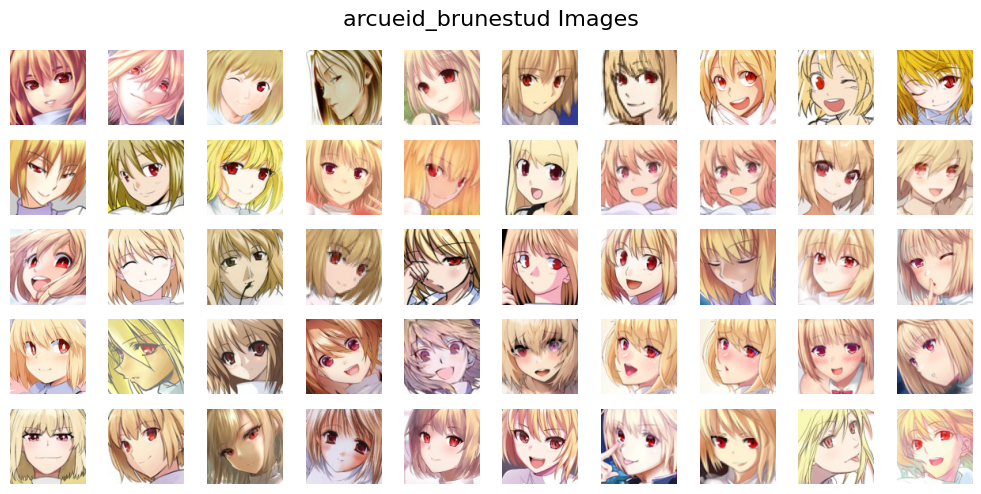

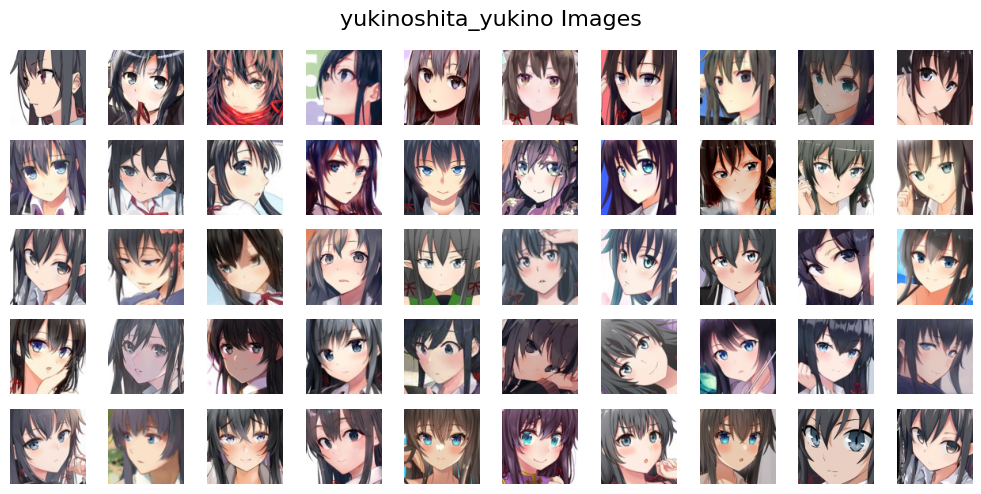

Train size: 80
Validation size: 20
Epoch 1, Train Loss: 0.2506, Val Loss: 0.0004
Epoch 2, Train Loss: 0.0748, Val Loss: 0.0290
Epoch 3, Train Loss: 0.0422, Val Loss: 0.0038
Epoch 4, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 5, Train Loss: 0.0003, Val Loss: 0.0000
Finished Training


In [18]:
def load_images_from_zip(zip_file):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        images = {'arcueid_brunestud': [], 'yukinoshita_yukino': []}
        for file_name in zip_ref.namelist():
            if file_name.startswith('arcueid_brunestud') and file_name.endswith('.jpg'):
                with zip_ref.open(file_name) as file:
                    img = Image.open(file).convert('RGB')
                    images['arcueid_brunestud'].append(np.array(img))
            elif file_name.startswith('yukinoshita_yukino') and file_name.endswith('.jpg'):
                with zip_ref.open(file_name) as file:
                    img = Image.open(file).convert('RGB')
                    images['yukinoshita_yukino'].append(np.array(img))
    return images

zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/yNB99OssvDWOrNTHf2Yuxw/data-practice.zip'

# Download the ZIP file
response = requests.get(zip_file_url)
zip_file_bytes = io.BytesIO(response.content)

# Load images from zip file
images = load_images_from_zip(zip_file_bytes)

print("Number of images of arcueid_brunestud:", len(images['arcueid_brunestud']))
print("Number of images of yukinoshita_yukino:", len(images['yukinoshita_yukino']))

# Plot images from 'arcueid_brunestud'
plot_images(images['arcueid_brunestud'], 'arcueid_brunestud Images')

# Plot images from 'yukinoshita_yukino'
plot_images(images['yukinoshita_yukino'], 'yukinoshita_yukino Images')

# TODO: Define a new AnimeDataset object for the new dataset.
# TODO: Split the new dataset into training and validation sets.
# TODO: Create DataLoader objects for the new training and validation sets.
# TODO: Define a new CNN model and train it on the new dataset.
# TODO: Evaluate the new model on the validation set.

# Load dataset
dataset = AnimeDataset(images, transform=transform, classes=['arcueid_brunestud', 'yukinoshita_yukino'])

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Generate a list of indices for the entire dataset
indices = list(range(len(dataset)))

# Split the indices into training and validation sets
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=seed)

# Create samplers for training and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create DataLoader objects for training and validation sets
train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=20, sampler=val_sampler)

# Print the sizes of the training and validation sets
print("Train size:", len(train_indices))
print("Validation size:", len(val_indices))

# Instantiate the model
model_new_dataset = AnimeCNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_new_dataset.parameters(), lr=0.001)

# Training loop
num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model_new_dataset.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_new_dataset(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model_new_dataset.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model_new_dataset(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print('Finished Training')

<details>
    <summary>Click here for Solution (Entire code)</summary>

```python
def load_images_from_zip(zip_file):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        images = {'arcueid_brunestud': [], 'yukinoshita_yukino': []}
        for file_name in zip_ref.namelist():
            if file_name.startswith('arcueid_brunestud') and file_name.endswith('.jpg'):
                with zip_ref.open(file_name) as file:
                    img = Image.open(file).convert('RGB')
                    images['arcueid_brunestud'].append(np.array(img))
            elif file_name.startswith('yukinoshita_yukino') and file_name.endswith('.jpg'):
                with zip_ref.open(file_name) as file:
                    img = Image.open(file).convert('RGB')
                    images['yukinoshita_yukino'].append(np.array(img))
    return images

zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/yNB99OssvDWOrNTHf2Yuxw/data-practice.zip'

# Download the ZIP file
response = requests.get(zip_file_url)
zip_file_bytes = io.BytesIO(response.content)

# Load images from zip file
images = load_images_from_zip(zip_file_bytes)

print("Number of images of arcueid_brunestud:", len(images['arcueid_brunestud']))
print("Number of images of yukinoshita_yukino:", len(images['yukinoshita_yukino']))

# Plot images from 'arcueid_brunestud'
plot_images(images['arcueid_brunestud'], 'arcueid_brunestud Images')

# Plot images from 'yukinoshita_yukino'
plot_images(images['yukinoshita_yukino'], 'yukinoshita_yukino Images')

# TODO: Define a new AnimeDataset object for the new dataset.
# TODO: Split the new dataset into training and validation sets.
# TODO: Create DataLoader objects for the new training and validation sets.
# TODO: Define a new CNN model and train it on the new dataset.
# TODO: Evaluate the new model on the validation set.

# Load dataset
dataset = AnimeDataset(images, transform=transform, classes=['arcueid_brunestud', 'yukinoshita_yukino'])

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Generate a list of indices for the entire dataset
indices = list(range(len(dataset)))

# Split the indices into training and validation sets
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=seed)

# Create samplers for training and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create DataLoader objects for training and validation sets
train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=20, sampler=val_sampler)

# Print the sizes of the training and validation sets
print("Train size:", len(train_indices))
print("Validation size:", len(val_indices))

# Instantiate the model
model_new_dataset = AnimeCNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_new_dataset.parameters(), lr=0.001)

# Training loop
num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model_new_dataset.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_new_dataset(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model_new_dataset.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model_new_dataset(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print('Finished Training')
```

</details>


## <a id='toc1_11_'></a>[Authors](#toc0_)


[Ricky Shi](https://www.linkedin.com/in/ricky-shi-ca/)


## <a id='toc1_12_'></a>[Contributors](#toc0_)


Copyright © 2024 IBM Corporation. All rights reserved.
